# 第 4 章：从头开始实现 GPT 模型以生成文本

In [609]:
from importlib.metadata import version

from torch.nn import LayerNorm
from torch.special import logit

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.7
torch version: 2.9.1+cu130
tiktoken version: 0.12.0


- 在本章中，我们实现了类似GPT的LLM架构；下一章将重点培训该LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="600px">

## 4.1 编码 LLM 架构

- 第 1 章讨论了 GPT 和 Llama 等模型，它们按顺序生成单词，并且基于原始 Transformer 架构的解码器部分
- 因此，这些LLMs通常被称为“类似解码器”的LLM
- 与传统的深度学习模型相比，LLM 更大，主要是由于其参数数量庞大，而不是代码量
- 我们会看到很多元素在LLM的架构中重复出现

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="500px">

- 在前面的章节中，为了便于说明，我们对token输入和输出使用了较小的嵌入尺寸，确保它们适合单个页面
- 在本章中，我们考虑类似于小型 GPT-2 模型的嵌入和模型大小
- 我们将专门编码最小 GPT-2 模型（1.24 亿个参数）的架构，如 Radford 等人的[语言模型是无监督多任务学习者](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) 中所述（请注意，初始报告将其列为 117M 个参数，但这后来在模型权重存储库）
- 第 6 章将展示如何将预训练权重加载到我们的实现中，这将与 345、762 和 15.42 亿个参数的模型大小兼容

- 1.24亿参数GPT-2模型的配置详细信息包括：

In [610]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # 词汇量
    "context_length": 1024,  # 上下文长度
    "emb_dim": 768,  # 嵌入尺寸
    "n_heads": 12,  # 注意力头数量
    "n_layers": 12,  # 层数
    "drop_rate": 0.1,  # 丢弃率
    "qkv_bias": False  # 查询键值偏差
}

- 我们使用短变量名以避免以后出现长行代码
- `"vocab_size"` 表示词汇量大小为 50,257 个单词，由第 2 章中讨论的 BPE 分词器支持
- `"context_length"` 表示模型的最大输入标记计数，由第 2 章中介绍的位置嵌入启用
- `"emb_dim"` 是 token 输入的嵌入大小，将每个输入 token 转换为 768 维向量
- `"n_heads"` 是第 3 章中实现的多头注意力机制中注意力头的数量
- `"n_layers"` 是模型中transformer块的数量，我们将在接下来的部分中实现
- `"drop_rate"` 是 dropout 机制的强度，在第 3 章中讨论； 0.1 表示在训练期间丢弃 10% 的隐藏单元以减轻过度拟合
- `"qkv_bias"` 决定多头注意力机制中的 `Linear` 层（来自第 3 章）在计算查询 (Q)、键 (K) 和值 (V) 张量时是否应包含偏差向量；我们将禁用此选项，这是现代LLM的标准做法；然而，稍后当将 OpenAI 中的预训练 GPT-2 权重加载到第 5 章的重新实现中时，我们将重新讨论这一点


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="600px">

In [611]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # 为TransformerBlock添加一个占位符
        self.trf_block = nn.Sequential(
            *[DummyTransformmerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        # 使用占位符LayerNorm
        self.final_norm = nn.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_emb = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_emb + pos_emb
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformmerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 一个简单的占位符

    def forward(self, x):
        #这个块什么都不做，只是返回它的输入。
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 这里的参数只是模仿LayerNorm接口。

    def forward(self, x):
        #这一层什么都不做，只是返回它的输入。
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="600px">

In [612]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [613]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.7867,  0.2203, -0.4508,  ..., -0.9936, -0.1412, -0.2999],
         [-0.0788,  0.3004, -0.2935,  ...,  0.1583,  0.8917,  0.8230],
         [ 0.3708,  1.1126, -0.3226,  ...,  0.8023, -0.0038,  0.3935],
         [ 0.0636,  1.0572, -0.2507,  ...,  0.7542, -0.0750, -0.6896]],

        [[-0.7208,  0.1351, -0.6014,  ..., -1.0272,  0.1729, -0.2920],
         [-0.5938,  0.4453, -0.0059,  ...,  0.3414,  0.0572,  1.0986],
         [ 0.2675,  0.8407, -0.4476,  ..., -0.0181, -0.1090,  0.2541],
         [-0.1035, -0.5901, -0.3932,  ...,  1.4022, -0.3188,  0.1304]]],
       grad_fn=<UnsafeViewBackward0>)


---

**注意**

- 如果您在 Windows上运行此代码，上面的结果值可能如下所示：

``` 
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.7867,  0.2203, -0.4508,  ..., -0.9936, -0.1412, -0.2999],
         [-0.0788,  0.3004, -0.2935,  ...,  0.1583,  0.8917,  0.8230],
         [ 0.3708,  1.1126, -0.3226,  ...,  0.8023, -0.0038,  0.3935],
         [ 0.0636,  1.0572, -0.2507,  ...,  0.7542, -0.0750, -0.6896]],

        [[-0.7208,  0.1351, -0.6014,  ..., -1.0272,  0.1729, -0.2920],
         [-0.5938,  0.4453, -0.0059,  ...,  0.3414,  0.0572,  1.0986],
         [ 0.2675,  0.8407, -0.4476,  ..., -0.0181, -0.1090,  0.2541],
         [-0.1035, -0.5901, -0.3932,  ...,  1.4022, -0.3188,  0.1304]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 由于这些只是随机数，因此不必担心，您可以毫无问题地继续本章的其余部分
- 造成这种差异的一个可能原因是“nn.Dropout”在不同操作系统上的行为不同，具体取决于 PyTorch 的编译方式，如 [此处在 PyTorch 问题跟踪器上](https://github.com/pytorch/pytorch/issues/121595) 所讨论的


---

## 4.2 使用层归一化对激活进行归一化

- 层归一化，也称为 LayerNorm（[Ba et al. 2016](https://arxiv.org/abs/1607.06450)），将神经网络层的激活集中在平均值 0 周围，并将其方差归一化为 1
- 这可以稳定训练并能够更快地收敛到有效重量
- 层归一化在变压器块内的多头注意模块之前和之后应用，我们将在稍后实现；它也应用于最终输出层之前

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="500px">

- 让我们通过简单的神经网络层传递一个小输入样本来看看层归一化是如何工作的：

In [614]:
torch.manual_seed(123)

#创建 2 个训练示例，每个示例有 5 个维度（特征）
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 让我们计算上面 2 个输入中每一个的均值和方差：

In [615]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 标准化独立地应用于两个输入（行）；使用 dim=-1 将计算应用于最后一个维度（在本例中为特征维度）而不是行维度

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="500px">

- 减去平均值并除以方差（标准差）的平方根，使输入在列（特征）维度上的平均值为 0，方差为 1：

In [616]:
out_norm = (out - mean) / torch.sqrt(var)
print("归一化层输出：\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("平均值:\n", mean)
print("方差:\n", var)

归一化层输出：
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
平均值:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
方差:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


-每个输入以0为中心，单位方差为1；为了提高可读性，我们可以禁用PyTorch的科学符号：

In [617]:
torch.set_printoptions(sci_mode=False)
print("平均值:\n", mean)
print("方差:\n", var)

平均值:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
方差:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


-以上，我们对每个输入的特征进行了归一化
-现在，使用相同的想法，我们可以实现一个`LayerNorm`类：

In [618]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**缩放和移动**

- 请注意，除了通过减去平均值和除以方差来执行归一化之外，我们还添加了两个可训练的参数，一个`scale`和一个`shift`参数
- 初始的`scale`（乘以1）和`shift`（加0）值没有任何影响；然而，`scale`和`shift`是可训练的参数，如果确定这样做会提高模型在训练任务中的表现，LLM会在训练期间自动调整这些参数
-这允许模型学习适当的缩放和移动，最适合它正在处理的数据
-注意，在计算方差的平方根之前，我们还添加了一个较小的值（`eps`）；这是为了避免方差为0时的除零错误

**偏方差**
- 在上面的方差计算中，设置`unbiased=False`意味着使用公式 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 计算方差，其中n是样本量（这里是特征或列的数量）；该公式不包括贝塞尔校正（在分母中使用`n-1`），因此提供了对方差的有偏估计
-对于llm，其中嵌入维数n非常大，使用n和n-1的区别
可以忽略不计
- 然而，GPT-2在规范化层中使用有偏差的方差进行训练，这就是为什么我们也采用了这种设置，因为我们将在后面的章节中加载预训练的权重

- 现在让我们在实践中尝试`LayerNorm`：

In [619]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [620]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("平均值:\n", mean)
print("方差:\n", var)

平均值:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
方差:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="500px">

## 4.3 使用 GELU 激活实现前馈网络

- 在本节中，我们实现一个小型神经网络子模块，用作LLMs中transformer块的一部分
- 我们从激活函数开始
- 在深度学习中，ReLU（整流线性单元）激活函数因其简单性和有效性而在各种神经网络架构中得到广泛使用
- 在LLM中，除了传统的ReLU之外，还使用了各种其他类型的激活函数；两个著名的例子是 GELU（高斯误差线性单元）和 SwiGLU（Swish 门控线性单元）
- GELU 和 SwiGLU 是更复杂、更平滑的激活函数，分别包含高斯和 sigmoid 门控线性单元，为深度学习模型提供更好的性能，这与 ReLU 更简单的分段线性函数不同

- GELU（[Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415)）可以通过多种方式实现；确切的版本定义为 GELU(x)=x⋅Φ(x)，其中 Φ(x) 是标准高斯分布的累积分布函数。
- 在实践中，通常会实现计算成本较低的近似值： $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$（原始 GPT-2 模型也是用这个近似值进行训练的）

In [621]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

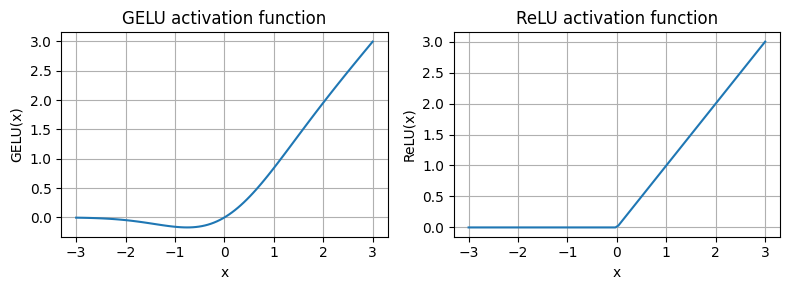

In [622]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# 一些样本数据
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 正如我们所看到的，ReLU是一个分段线性函数，如果输入为正则直接输出；否则，输出零
- GELU 是一个平滑的非线性函数，近似于 ReLU，但对于负值具有非零梯度（除了大约 -0.75）

- 接下来，让我们实现小型神经网络模块`FeedForward`，稍后我们将在 LLM 的transformer块中使用它：

In [623]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [624]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [625]:
ffn = FeedForward(GPT_CONFIG_124M)

# 输入形状：[batch_size， num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)

print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="500px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="500px">

## 4.4 添加快捷连接

- 接下来，我们来谈谈快捷连接背后的概念，也称为跳过或剩余连接
- 最初，在计算机视觉的深度网络（残差网络）中提出了快捷连接，以减轻梯度消失问题
- 快捷连接为梯度流经网络创建了一条替代的较短路径
- 这是通过将一层的输出添加到后面一层的输出来实现的，通常跳过中间的一层或多层
- 让我们用一个小示例网络来说明这个想法：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="500px">

- 在代码中，它看起来像这样：

In [626]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
        ])

    def forward(self, x):
        for layer in self.layers:
            # 计算当前层的输出
            layer_output = layer(x)
            # 检查是否可以应用快捷方式
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # 前向传递
    output = model(x)
    target = torch.tensor([[0.]])
    # 根据目标的接近程度计算损失和输出是

    loss = nn.MSELoss()
    loss = loss(output, target)

    # 向后传递计算梯度
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 打印权重的平均绝对梯度
            print(f"{name} 梯度平均值为 {param.grad.abs().mean().item()}")

- 让我们首先打印梯度值**没有**快捷方式连接：

In [627]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight 梯度平均值为 0.0011121002025902271
layers.1.0.weight 梯度平均值为 0.001235906733199954
layers.2.0.weight 梯度平均值为 0.001773848314769566
layers.3.0.weight 梯度平均值为 0.003020398784428835


- 接下来，让我们**用**快捷方式连接打印渐变值：

In [628]:
torch.manual_seed(123)

model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight 梯度平均值为 0.25530001521110535
layers.1.0.weight 梯度平均值为 0.21116767823696136
layers.2.0.weight 梯度平均值为 0.29930680990219116
layers.3.0.weight 梯度平均值为 0.2527087330818176


- 正如我们根据上面的输出所看到的，快捷连接防止梯度在早期层中消失（朝向“layer.0”）
- 接下来，当我们实现变压器块时，我们将使用这种快捷连接的概念

## 4.5 连接transformer块中的注意力层和线性层

- 在本节中，我们现在将前面的概念结合到所谓的transformer块中
- transformer块将前一章中的因果多头注意力模块与线性层（我们在前面部分中实现的前馈神经网络）相结合
- 此外，transformer块还使用了dropout和shortcut连接

In [629]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.dropout_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 注意块的快捷连接
        shortcut = x
        x = self.norm1(x)  #Shape [batch_size, num_tokens, emb_size]
        x = self.att(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut  #添加原始输入

        # 前馈块的快捷连接
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut  #添加原始输入
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="500px">

- 假设我们有2个输入样本，每个样本有6个标记，其中每个标记是一个768维的嵌入向量；然后，这个变压器块应用自关注，然后是线性层，以产生类似大小的输出
- 你可以把输出看作是我们在前一章讨论的上下文向量的增强版本

In [630]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  #Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape 输入形状:", x.shape)
print("Output shape 输出形式:", output.shape)

Input shape 输入形状: torch.Size([2, 4, 768])
Output shape 输出形式: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="500px">

## 4.6编写GPT模型

- 我们差不多完成了：现在让我们将transformer 块插入到我们在本章开头编写的体系结构中，以便我们获得可用的GPT体系结构
- 注意transformer 块重复多次；对于最小的124M GPT-2型号，我们重复12次：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="500px">

- 相应的代码实现，其中`cfg["n_layers"] = 12`:

In [631]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 使用124M参数模型的配置，我们现在可以用随机初始权重实例化这个GPT模型，如下所示：

In [632]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch 输入批处理:\n", batch)
print("\nOutput shape 输出形状:", out.shape)
print(out)

Input batch 输入批处理:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape 输出形状: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- 我们将在下一章训练这个模型
- 不过，关于它的尺寸，我们之前称它为124M参数模型我们可以再核对一下这个数字：

In [633]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters 参数总数: {total_params:,}")

Total number of parameters 参数总数: 163,009,536


- 正如我们在上面看到的，这个模型有 163M，而不是 124M 参数；为什么？
- 在最初的 GPT-2 论文中，研究人员应用了权重绑定，这意味着他们重用了 token 嵌入层（`tok_emb`）作为输出层，这意味着设置 `self.out_head.weight = self.tok_emb.weight`
- token嵌入层将 50,257 维单热编码输入令牌投影为 768 维嵌入表示
- 输出层将 768 维嵌入投影回 50,257 维表示，以便我们可以将它们转换回单词（下一节将详细介绍）
- 因此，嵌入层和输出层具有相同数量的权重参数，正如我们根据权重矩阵的形状所看到的那样
- 但是，关于其大小的快速说明：我们之前将其称为 124M 参数模型；我们可以仔细检查这个数字，如下所示：

In [634]:
print("Token embedding layer shape(Token嵌入层形状):", model.tok_emb.weight.shape)
print("Output layer shape(输出层形状):", model.out_head.weight.shape)

Token embedding layer shape(Token嵌入层形状): torch.Size([50257, 768])
Output layer shape(输出层形状): torch.Size([50257, 768])


- 在最初的 GPT-2 论文中，研究人员重新使用了 token 嵌入矩阵作为输出矩阵
- 相应地，如果我们减去输出层的参数数量，我们将得到一个124M参数的模型：

In [635]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters consiering weight tying 考虑权重绑定的可训练参数数量: {total_params_gpt2:,}")

Number of trainable parameters consiering weight tying 考虑权重绑定的可训练参数数量: 124,412,160


- 在实践中，我发现在没有权重绑定的情况下训练模型更容易，这就是我们没有在这里实现它的原因
- 但是，稍后当我们在第 5 章中加载预训练权重时，我们将重新审视并应用这个权重绑定的想法
- 最后，我们可以如下计算模型的内存需求，这可以作为有用的参考点：

In [636]:
# 计算总大小（以字节为单位）（假设float32，每个参数4字节）
total_size_bytes = total_params * 4

# 转换为兆字节
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- 练习：您可m以尝试以下其他配置，这些配置也在 [GPT-2 论文](https://scholar.google.com/itations?view_op=view_itation&hl=en&user=dOad5HoAAAAJ&itation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C) 中引用。
-
    - **GPT2-small** （我们已经实现的124M配置）:
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16

    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20

    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 生成文本

- 像我们上面实现的 GPT 模型这样的 LLM 用于一次生成一个单词

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="500px">

- 下面的`generate_text_simple`函数实现了贪婪解码，这是一种简单快速的生成文本的方法
- 在贪婪解码中，在每一步中，模型都会选择概率最高的单词（或标记）作为其下一个输出（最高的 logit 对应于最高的概率，因此从技术上讲，我们甚至不必显式计算 softmax 函数）
- 在下一章中，我们将实现更高级的 `generate_text` 函数
- 下图描述了 GPT 模型如何在给定输入上下文的情况下生成下一个单词标记

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="700px">

In [637]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx 是当前上下文中的 (batch, n_tokens) 索引数组
    for _ in range(max_new_tokens):
        # 如果当前上下文超出了支持的上下文大小，则裁剪当前上下文
        # 例如，如果 LLM 仅支持 5 个令牌，并且上下文大小为 10
        # 那么只有最后 5 个标记被用作上下文

        idx_cond = idx[:,-context_size:]
        # 获取预测结果
        with torch.no_grad():
            logits = model(idx_cond)

        # 只关注最后一个时间步
        # (batch, n_tokens, vocab_size) 变为 (batch, vocab_size)
        logits = logits[:, -1, :]

        # 应用softmax来获取概率
        probas = torch.softmax(logits, dim=-1)
        # 获取概率值最高的词汇条目的idx
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        # 将采样索引附加到运行序列中
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

- 上面的 `generate_text_simple` 实现了一个迭代过程，一次创建一个token


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="700px">

- 让我们准备一个输入示例：

In [638]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded 编码:",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape 编码张量形式:",encoded_tensor.shape)

encoded 编码: [15496, 11, 314, 716]
encoded_tensor.shape 编码张量形式: torch.Size([1, 4])


In [639]:
model.eval()

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output 输出:",out)
print("Output  输出长度:",len(out[0]))

Output 输出: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output  输出长度: 10


- 删除批量维度并转换回文本：

In [640]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 请注意，模型未经训练；因此上面的随机输出文本
- 我们将在下一章训练模型

## 总结和要点

- 请参阅 [./gpt.py](./gpt.py) 脚本，这是一个独立的脚本，其中包含我们在此 Jupyter 笔记本中实现的 GPT 模型